Minimal example of RelaxedBernoulliStraightThrough used in 1D Gaussian Mixture model, with custom guide based on AutoHierarchicalNormalMessenger.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoGuideList, AutoHierarchicalNormalMessenger
from pyro.infer import SVI, Trace_ELBO, infer_discrete
from pyro.infer import Predictive
from pyro.poutine import block

Add mean to RelaxedBernoulliStraightThrough to make it useable with Messenger guides:

In [2]:
from pyro.distributions import RelaxedBernoulliStraightThrough
RelaxedBernoulliStraightThrough.mean = property(lambda self: self.probs)

Produce some data from two Normal distributions with different means:

In [3]:
def generate_data(n_components = 2, n_observations = 100, ps = 0.9):
    
    mus = torch.tensor((4., 4.))
    b = pyro.sample('b', dist.Bernoulli(probs = ps).expand([n_observations]).to_event(1))
                             
    mean = mus[0] + mus[1]*b
    
    data = pyro.sample("data_target", dist.Normal(loc = mean, scale = 1.))
    
    return data, b

Samples are discrete during sampling:

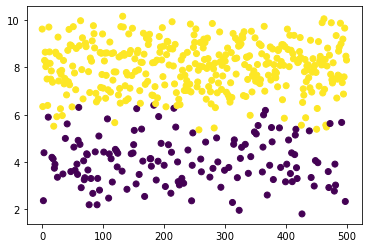

In [4]:
n_components = 2
n_observations = 500
ps = 0.75
data, b = generate_data(n_components, n_observations, ps)
plt.scatter(range(len(data)), data, c = b)

Our model using the Bernoulli distribution to assign observations to components:

In [5]:
def model(data, n_components, n_observations, i):
    
    ps = pyro.sample('ps', dist.Dirichlet(torch.ones(n_components)/10.))
    mus = pyro.sample('mus', dist.Gamma(20,2).expand([n_components]).to_event(1))
    b = pyro.sample('b', dist.Bernoulli(probs = ps[0]).expand([n_observations]).to_event(1))                    
    
    mean = mus[0] + mus[1]*b
    
    pyro.sample("data_target", dist.Normal(loc = mean, scale = torch.tensor(1.)).to_event(1), obs = data)

Define custom guide:

In [6]:
def b_guide(data, n_components, n_observations, i):
    b = pyro.sample("b", dist.RelaxedBernoulliStraightThrough(probs=0.5,
                                                          temperature=torch.tensor(1.0)).expand([n_observations]).to_event(1))
    if i == 10:
        print(b)

guide = AutoGuideList(model)
guide.append(AutoHierarchicalNormalMessenger(block(model, hide=["b"])))
guide.append(b_guide)

Training:

In [7]:
# Train model:
n_iterations = 1000
optim = pyro.optim.Adam({'lr': 0.1})
elbo = Trace_ELBO()
svi = SVI(model, guide, optim, loss=elbo)
for i in range(n_iterations):
    loss = svi.step(data, n_components, n_observations, i)

posterior = Predictive(model, guide=guide, num_samples=1)(data, n_components, n_observations, i)

/nfs/team283/aa16/software/miniconda3/envs/pyro_practice/lib/python3.9/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'data_target'}
  warnings.warn(


tensor([0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1.,
        0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0.,
        0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1.,
        0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
        1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
        1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
        1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0.,
        0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0.,
        1., 1., 1., 0., 1., 0., 1., 1., 

Evaluate model:

In [9]:
print('Percentage correctly classified: ', np.array(torch.sum(b - posterior['b'] == 0)/len(b)))
b = torch.abs(b - 1)
print('Percentage correctly classified after switching categories: ', np.array(torch.sum(b - posterior['b'] == 0)/len(b)))
print('Percentage classified in category 1: ', np.array(torch.sum(posterior['b'] == 1)/len(b)))

Percentage correctly classified:  0.502
Percentage correctly classified after switching categories:  0.498
Percentage classified in category 1:  0.5
